# Objective:
    1. Show how the dataset is structured
    2. Explore a bit about customer behaviour based on the data and do basic customer segmentation
    3. Recommendations for future analysis

This dataset was taken from the Retail Rocket Recommender System dataset: https://www.kaggle.com/retailrocket/ecommerce-dataset/home

And data was between June 2, 2015 and August 1, 2015

In [82]:
import pandas as pd
import numpy as np

import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Let us load the Retail Rocket CSV files into DataFrames

In [275]:
events_df = pd.read_csv("/storage/work/ajk6604/DS340w/events.csv")
category_tree_df = pd.read_csv("/storage/work/ajk6604/DS340w/category_tree.csv")
item_properties_1_df = pd.read_csv("/storage/work/ajk6604/DS340w/item_properties_part1.csv")
item_properties_2_df = pd.read_csv("/storage/work/ajk6604/DS340w/item_properties_part2.csv")

# Let's take a peek at the Events dataframe

In [276]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [277]:
len(events_df)

2756101

The timestamp portion is in Unix Epoch format e.g. 1433221332117 will be converted to Tuesday, 2 June 2015 5:02:12.117 AM GMT

Visitor Id is the unique user currently browsing the website

Event is what the user is currently doing in that current timestamp

Transaction ID will only have value if the user made a purchase as shown below

In [85]:
#Which event has a value in its transaction id
events_df[events_df.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

The rest of the events with NaN transaction ids are either view or add to cart

In [86]:
#Which event/s has a null value
events_df[events_df.transactionid.isnull()].event.unique()

array(['view', 'addtocart'], dtype=object)

# Now let's take a look at the Item Properties

In [87]:
item_properties_1_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


Timestamp is still the same Unix / Epoch format

Item id will be the unique item identifier

Property is the Item's attributes such as category id and availability while the rest are hashed for confidentiality purposes

Value is the item's property value e.g. availability is 1 if there is stock and 0 otherwise

Note: Values that start with "n" indicate that the value preceeding it is a number e.g. n277.200 is equal to 277.2

# Category IDs

In [88]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


Category IDs explain the relationship of different products with each other e.g. Category ID 1016 is a child of Parent ID 213.

Below shows the number of items under category id 1016

In [89]:
item_properties_1_df.loc[(item_properties_1_df.property == 'categoryid') & (item_properties_1_df.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
6363096,1431226800000,339403,categoryid,1016
8597591,1431226800000,161686,categoryid,1016
7942027,1431226800000,418837,categoryid,1016
10230975,1431226800000,85538,categoryid,1016
7280176,1431226800000,278463,categoryid,1016


# Customer behaviour exploration

I think it's prudent to start separating customers into two categories, those who purchased something and those who didn't

In [9]:
#Let's get all the customers who bought something
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

Assumptions:
    1. Since we have no information whether there were any repeat users who bought something from the site, I'll just have to assume for now that the 11,719 visitors are unique and made at least a single purchase

In [10]:
#Let's get all unique visitor ids as well
all_customers = events_df.visitorid.unique()
all_customers.size

1407580

Out of 1,407,580 unique visitor ids, let's take out the ones that bought something

In [11]:
customer_browsed = [x for x in all_customers if x not in customer_purchased]

In [12]:
len(customer_browsed)

1395861

So there were actually 1,395,861 unique site visitors who didn't buy anything, again assuming that there were no repeat users with different visitor IDs

In [13]:
#Another way to do it using Numpy
temp_array = np.isin(customer_browsed, customer_purchased)
temp_array[temp_array == False].size

1395861

In [14]:
#A sample list of the customers who bought something
customer_purchased[:10]

array([ 599528,  121688,  552148,  102019,  189384,  350566,  404403,
        505565,  945184, 1406787])

# Below is a snapshot of visitor id 102019 and their buying journey from viewing to transaction (purchase)

In [15]:
events_df[events_df.visitorid == 102019].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
19690,1433175714335,102019,view,49521,NaN
19501,1433175801314,102019,addtocart,49521,NaN
14842,1433175812596,102019,view,150318,NaN
19573,1433175871497,102019,view,49521,NaN
8701,1433175894837,102019,view,49521,NaN
19708,1433175945872,102019,view,150318,NaN
8740,1433176042269,102019,view,49521,NaN
814,1433176736375,102019,transaction,150318,13556.0
19724,1433176736422,102019,transaction,49521,13556.0


If we want to convert the UNIX / Epoch time format to readable format then just do the code below

In [16]:
tz = int('1433221332')
new_time = datetime.datetime.fromtimestamp(tz)
new_time.strftime('%Y-%m-%d %H:%M:%S')

'2015-06-02 01:02:12'

In [17]:
tz = int('1438400163')
new_time = datetime.datetime.fromtimestamp(tz)
new_time.strftime('%Y-%m-%d %H:%M:%S')

'2015-07-31 23:36:03'

# What insights can we offer the visitor to guide them in their buying journey?

-perhaps we can offer them a list of what previous visitors bought together with the item they are currently viewing

In [18]:
# Firstly let's create an array that lists visitors who made a purchase
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
    
purchased_items = []
    
# Create another list that contains all their purchases 
for customer in customer_purchased:

    #Generate a Pandas series type object containing all the visitor's purchases and put them in the list
    purchased_items.append(list(events_df.loc[(events_df.visitorid == customer) & (events_df.transactionid.notnull())].itemid.values))                                  

So now all items purchased together are presented as a list of lists, shown below are the first 5 samples

In [19]:
purchased_items[:5]

[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044]]

In [20]:
# Write a function that would show items that were bought together (same of different dates) by the same customer
def recommender_bought_bought(item_id, purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

# So now we can present to the visitor a list of the other items a customer previously bought along with what item the current visitor is viewing e.g. item number 302422

In [21]:
recommender_bought_bought(302422, purchased_items)

[105792, 200793, 12836, 80582, 380775, 15335, 400969, 25353, 237753, 317178]

That was a very crude way of recommending other items to the visitor

# What other insights can we gather from the items that were viewed, added to cart and sold?

# Can we perhaps cluster the visitors and see if classes appear?

For that I will need to create a new dataframe and engineer a few features for it

How many unique visitors did we have for the site from June 2, 2015 to August 1, 2015?

Shown below are the total number of visitors for that time duration (was also shown at the close to the start of this paper)

In [22]:
#Put all the visitor id in an array and sort it ascendingly
all_visitors = events_df.visitorid.sort_values().unique()
all_visitors.size

1407580

In [23]:
buying_visitors = events_df[events_df.event == 'transaction'].visitorid.sort_values().unique()
buying_visitors.size

11719

Out of 1,407,580 visitors, ony 11,719 bought something so around 1,395,861 visitors just viewed items

In [24]:
viewing_visitors_list = list(set(all_visitors) - set(buying_visitors))


Now lets create a function that creates a dataframe with new features: visitorid, number of items viewed, total viewcount, bought something or not

In [25]:
def create_dataframe(visitor_list):
    
    array_for_df = []
    for index in visitor_list:

        #Create that visitor's dataframe once
        v_df = events_df[events_df.visitorid == index]

        temp = []
        #Add the visitor id
        temp.append(index)

        #Add the total number of unique products viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)

        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        #Then put either a zero or one if they made a purchase
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)
    
    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])

Let's apply this to buying visitors first

In [26]:
buying_visitors_df = create_dataframe(buying_visitors)

In [27]:
buying_visitors_df.shape

(11719, 5)

I think I'll only get around 27,821 samples from the viewing visitors list so that there is a 70-30 split for training and test data. 

In [28]:
#Let's shuffle the viewing visitors list for randomness
import random
random.shuffle(viewing_visitors_list)

In [29]:
viewing_visitors_df = create_dataframe(viewing_visitors_list[0:27820])

In [30]:
viewing_visitors_df.shape

(27820, 5)

Now let's combine the two dataframes

In [31]:
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

Let's plot main_df and see if anything comes up

In [32]:
main_df.head(10)

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1
3,419,3,4,1,1
4,539,1,4,1,1
5,627,12,17,1,1
6,795,7,14,1,1
7,914,1,1,1,1
8,964,1,6,1,1
9,1032,3,5,1,1


In [33]:
#Let's shuffle main_df first
main_df = main_df.sample(frac=1)

/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


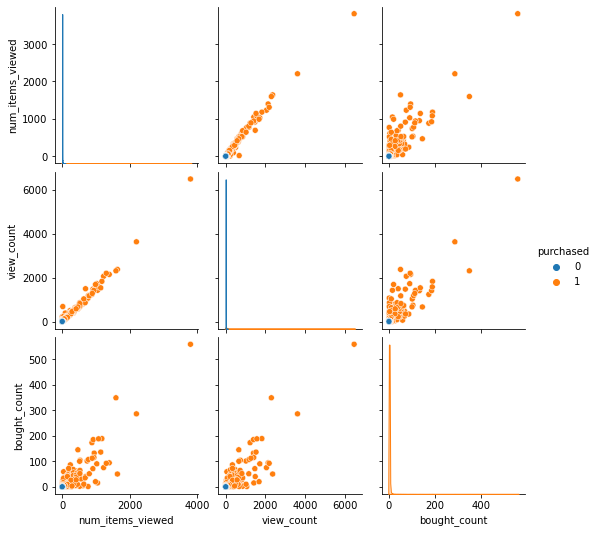

In [34]:
#Plot the data
sns.pairplot(main_df, x_vars = ['num_items_viewed', 'view_count', 'bought_count'],
             y_vars = ['num_items_viewed', 'view_count', 'bought_count'],  hue = 'purchased')

The plot above clearly indicates that the higher the view count, the higher the chances of that visitor buying something. Duh!

# Since the relationship is Linear, let's try a simple Logistic Regression model to predict future visitor purchase behaviour

We separate the features (drop visitorid since it's categorical data and bought count) and the target (which is whether the visitor bought something or not)

In [35]:
main_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
26838,1215922,1,1,0,0
31597,1231115,1,1,0,0
32497,1241898,2,3,0,0
11210,1344553,4,7,2,1
5747,702000,3,11,2,1
...,...,...,...,...,...
2504,305493,3,3,2,1
23031,1060386,7,11,0,0
28325,888416,1,1,0,0
12074,857931,1,1,0,0


In [36]:
X = main_df.drop(['purchased', 'visitorid', 'bought_count'], axis = 'columns')
y = main_df.purchased

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

In [38]:
logreg = LogisticRegression()

In [39]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
# Let's now use the model to predict the test features
y_pred_class = logreg.predict(X_test)

In [41]:
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy =  0.7983


# So our model's accuracy in predicting buying visitors is around 79.46%

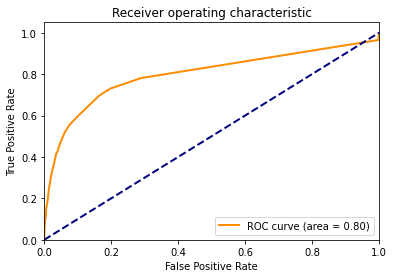

In [42]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

The graph above shows the accuracy of our binary classifier (Logistic Regression). Just means that the closer the orange curve leans to the top left hand part of the graph, the better the accuracy.

# My Implementation Using Decision Tree Classification to help improve this model

In [43]:
#pip install catboost

In [44]:
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

## Make an example model to make sure it runs

In [45]:
# Creating CatBoost Model
model = CatBoostClassifier(iterations=350, learning_rate=0.1, depth=6, loss_function='Logloss')

# Training
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=25, verbose=10)

# Predict
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

0:	learn: 0.6366150	test: 0.6373860	best: 0.6373860 (0)	total: 65.6ms	remaining: 22.9s
10:	learn: 0.4510896	test: 0.4537411	best: 0.4537411 (10)	total: 104ms	remaining: 3.21s
20:	learn: 0.4289354	test: 0.4320081	best: 0.4320081 (20)	total: 142ms	remaining: 2.22s
30:	learn: 0.4242445	test: 0.4273908	best: 0.4273908 (30)	total: 178ms	remaining: 1.83s
40:	learn: 0.4223937	test: 0.4258624	best: 0.4258624 (40)	total: 216ms	remaining: 1.63s
50:	learn: 0.4214827	test: 0.4253033	best: 0.4253033 (50)	total: 253ms	remaining: 1.49s
60:	learn: 0.4210493	test: 0.4251943	best: 0.4251943 (60)	total: 292ms	remaining: 1.39s
70:	learn: 0.4205721	test: 0.4249738	best: 0.4249641 (67)	total: 330ms	remaining: 1.3s
80:	learn: 0.4202996	test: 0.4248870	best: 0.4248870 (80)	total: 369ms	remaining: 1.22s
90:	learn: 0.4200201	test: 0.4247900	best: 0.4247813 (89)	total: 407ms	remaining: 1.16s
100:	learn: 0.4196078	test: 0.4245951	best: 0.4245887 (99)	total: 445ms	remaining: 1.1s
110:	learn: 0.4192844	test: 0.4244

# Use Grid Search Cross Validation to help find best parameters

In [46]:
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier(verbose=0)

In [47]:
param_grid = {
    'iterations': [350],
    'learning_rate': [0.1, 0.01, 0.05, 0.001],
    'depth': [6, 8, 10, 12, 16],
    "loss_function":['Logloss'] ,
    "early_stopping_rounds": [25]
}

In [48]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose = 0)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x14ad1e400670>,
             param_grid={'depth': [6, 8, 10, 12, 16],
                         'early_stopping_rounds': [25], 'iterations': [350],
                         'learning_rate': [0.1, 0.01, 0.05, 0.001],
                         'loss_function': ['Logloss']},
             scoring='accuracy')

In [49]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_iteration = best_model.get_best_iteration()

In [50]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Best Iteration", best_iteration)
#Best Parameters: {'depth': 8, 'early_stopping_rounds': 25, 'iterations': 350, 'learning_rate': 0.05, 'loss_function': 'Logloss'}
#Best Score: 0.8222767018640251
#Best Iteration None

Best Parameters: {'depth': 8, 'early_stopping_rounds': 25, 'iterations': 350, 'learning_rate': 0.05, 'loss_function': 'Logloss'}
Best Score: 0.8222767018640251
Best Iteration None


## Here would be our best model based on Grid Search 

In [53]:
model = CatBoostClassifier(iterations=350, learning_rate=0.05, depth=8, loss_function='Logloss')
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=25, verbose=10)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

0:	learn: 0.6638759	test: 0.6642920	best: 0.6642920 (0)	total: 8.64ms	remaining: 3.02s
10:	learn: 0.5072719	test: 0.5091961	best: 0.5091961 (10)	total: 60.9ms	remaining: 1.88s
20:	learn: 0.4539465	test: 0.4566684	best: 0.4566684 (20)	total: 114ms	remaining: 1.79s
30:	learn: 0.4364354	test: 0.4393883	best: 0.4393883 (30)	total: 170ms	remaining: 1.75s
40:	learn: 0.4291358	test: 0.4322599	best: 0.4322599 (40)	total: 224ms	remaining: 1.69s
50:	learn: 0.4255605	test: 0.4288875	best: 0.4288875 (50)	total: 279ms	remaining: 1.64s
60:	learn: 0.4236089	test: 0.4270798	best: 0.4270798 (60)	total: 335ms	remaining: 1.58s
70:	learn: 0.4225842	test: 0.4261732	best: 0.4261732 (70)	total: 388ms	remaining: 1.52s
80:	learn: 0.4218998	test: 0.4256743	best: 0.4256743 (80)	total: 444ms	remaining: 1.47s
90:	learn: 0.4213139	test: 0.4252873	best: 0.4252873 (90)	total: 496ms	remaining: 1.41s
100:	learn: 0.4209145	test: 0.4250942	best: 0.4250878 (97)	total: 551ms	remaining: 1.36s
110:	learn: 0.4206237	test: 0.4

# How can we change up the data

In [460]:
events_df = pd.read_csv("/storage/work/ajk6604/DS340w/events.csv")
category_tree_df = pd.read_csv("/storage/work/ajk6604/DS340w/category_tree.csv")
item_properties_1_df = pd.read_csv("/storage/work/ajk6604/DS340w/item_properties_part1.csv")
item_properties_2_df = pd.read_csv("/storage/work/ajk6604/DS340w/item_properties_part2.csv")

In [461]:
events_df.head(5)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [462]:
category_tree_df.head(5)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [463]:
item_properties_1_df.tail(5)


,timestamp,itemid,property,value
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566
10999998,1436065200000,464846,790,n410640.000


In [464]:
item_properties_2_df.tail(5)

,timestamp,itemid,property,value
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062
9275902,1442113200000,275768,888,888666 n10800.000 746840 1318567


In [465]:
item_properties = item_properties_1_df.append(item_properties_2_df, ignore_index=True)
item_properties

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
20275897,1433646000000,236931,929,n12.000
20275898,1440903600000,455746,6,150169 639134
20275899,1439694000000,347565,686,610834
20275900,1433646000000,287231,867,769062


In [466]:
item_properties.loc[(item_properties.property == 'categoryid') & (item_properties.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
18236968,1431226800000,6777,categoryid,1016
8597591,1431226800000,161686,categoryid,1016
9496408,1431226800000,276491,categoryid,1016
17880130,1431226800000,443058,categoryid,1016
18202530,1431226800000,462004,categoryid,1016


# Make column with values only with a categoryid or NAN for ones without

In [467]:
cat_prop = item_properties
cat_prop.head(5)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [468]:
len(cat_prop)

20275902

## Add the parentid to the values

In [469]:
df1 = pd.DataFrame(cat_prop)
df2 = pd.DataFrame(category_tree_df)
df2.rename(columns={'categoryid': 'value'}, inplace=True)
df2['value'] = df2['value'].astype(str)
df1['value'] = df1['value'].astype(str)

In [470]:
# Performing a left join on value in df1 and df2
cat_prop = pd.merge(df1, df2, on='value', how='left')
cat_prop.head(5)

,timestamp,itemid,property,value,parentid
0,1435460400000,460429,categoryid,1338,1278.0
1,1441508400000,206783,888,1116713 960601 n277.200,NaN
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,NaN
3,1431226800000,59481,790,n15360.000,NaN
4,1431831600000,156781,917,828513,NaN


In [471]:
len(cat_prop)

20275902

## Drop not needed columns and rows

In [472]:
cat_prop_drop = ["timestamp", "value", "property"]
cat_prop.drop(columns=cat_prop_drop, inplace=True)
# Find unique 'itemid' values
unique_itemids = cat_prop['itemid'].unique()

# Filter cat_prop to keep rows with unique 'itemid' values
cat_prop_filtered = cat_prop[cat_prop['itemid'].isin(unique_itemids)]

# Keep only the rows where 'itemid' values occur exactly once
cat_prop = cat_prop_filtered.drop_duplicates(subset='itemid')
len(cat_prop)

417053

In [473]:
cat_prop.head(5)

,itemid,parentid
0,460429,1278.0
1,206783,NaN
2,395014,NaN
3,59481,NaN
4,156781,NaN


## Join on the events table

In [474]:
events_df.head(5)
len(events_df)

2756101

In [475]:
events_df = pd.merge(events_df, cat_prop, on=('itemid'), how='left')
events_df.head(5)

,timestamp,visitorid,event,itemid,transactionid,parentid
0,1433221332117,257597,view,355908,NaN,NaN
1,1433224214164,992329,view,248676,NaN,NaN
2,1433221999827,111016,view,318965,NaN,NaN
3,1433221955914,483717,view,253185,NaN,NaN
4,1433221337106,951259,view,367447,NaN,NaN


In [476]:
len(events_df)

2756101

In [477]:
main_df.head(5)

,visitorid,num_items_viewed,view_count,purchased
0,172,22,33,1
1,186,1,2,1
2,264,2,3,1
3,419,3,4,1
4,539,1,4,1


# Lets now combine this main_df with the one we created above

In [478]:
final_df = pd.merge(main_df, events_df, on=('visitorid'), how='left')
final_df.head(5)

,visitorid,num_items_viewed,view_count,purchased,timestamp,event,itemid,transactionid,parentid
0,172,22,33,1,1439602029037,view,465522,NaN,NaN
1,172,22,33,1,1439600798438,view,465522,NaN,NaN
2,172,22,33,1,1439599816912,addtocart,10034,NaN,NaN
3,172,22,33,1,1439599752998,view,10034,NaN,NaN
4,172,22,33,1,1439602141230,transaction,465522,9725.0,NaN


In [479]:
final_df = final_df.drop(['transactionid',"event","itemid","timestamp"], axis = 'columns')
final_df.head(5)

,visitorid,num_items_viewed,view_count,purchased,parentid
0,172,22,33,1,NaN
1,172,22,33,1,NaN
2,172,22,33,1,NaN
3,172,22,33,1,NaN
4,172,22,33,1,NaN


In [480]:
final_df[['purchased',"num_items_viewed", "parentid","view_count"]] = final_df[['purchased',"num_items_viewed", "parentid","view_count"]].fillna(0)
final_df.head(5)

,visitorid,num_items_viewed,view_count,purchased,parentid
0,172,22,33,1,0.0
1,172,22,33,1,0.0
2,172,22,33,1,0.0
3,172,22,33,1,0.0
4,172,22,33,1,0.0


## We now have every visitor and we get the count of the parentid to see if the more parentids means that it is more purchasable.

In [481]:
result = final_df.groupby(['visitorid',"num_items_viewed", "purchased","view_count"])['parentid'].nunique().reset_index()
result = result.rename(columns={'column3': 'parentid_count'})
result.head(5)

,visitorid,num_items_viewed,purchased,view_count,parentid
0,33,1,0,1,1
1,51,5,0,6,2
2,78,1,0,1,1
3,116,1,0,1,1
4,160,1,0,1,1


# We can now run the same model above to see if the parentid count helps

In [482]:
X = result.drop(['purchased', 'visitorid'], axis = 'columns')
y = result["purchased"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

In [485]:
model = CatBoostClassifier(iterations=350, learning_rate=0.05, depth=8, loss_function='Logloss')
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=25, verbose=10)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

0:	learn: 0.6637423	test: 0.6636676	best: 0.6636676 (0)	total: 6.15ms	remaining: 2.15s
10:	learn: 0.5037220	test: 0.5035302	best: 0.5035302 (10)	total: 61ms	remaining: 1.88s
20:	learn: 0.4547249	test: 0.4549047	best: 0.4549047 (20)	total: 115ms	remaining: 1.8s
30:	learn: 0.4352534	test: 0.4356513	best: 0.4356513 (30)	total: 170ms	remaining: 1.75s
40:	learn: 0.4272300	test: 0.4278724	best: 0.4278724 (40)	total: 225ms	remaining: 1.7s
50:	learn: 0.4236027	test: 0.4244090	best: 0.4244090 (50)	total: 277ms	remaining: 1.62s
60:	learn: 0.4213612	test: 0.4224349	best: 0.4224349 (60)	total: 331ms	remaining: 1.57s
70:	learn: 0.4201203	test: 0.4213328	best: 0.4213328 (70)	total: 384ms	remaining: 1.51s
80:	learn: 0.4194010	test: 0.4208454	best: 0.4208454 (80)	total: 435ms	remaining: 1.44s
90:	learn: 0.4187512	test: 0.4204218	best: 0.4204218 (90)	total: 489ms	remaining: 1.39s
100:	learn: 0.4183197	test: 0.4201603	best: 0.4201603 (100)	total: 543ms	remaining: 1.34s
110:	learn: 0.4179136	test: 0.4199

## We can see that there is some small improvement when we add the parentid around a 1% increase. 

# Now we can try using Bagging a technique used in one of my papers

In [486]:
model_bagging = CatBoostClassifier(bootstrap_type='Bayesian',iterations=350, learning_rate=0.05, depth=8, loss_function='Logloss')
model_bagging.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=25, verbose=10)

y_pred = model_bagging.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

0:	learn: 0.6637423	test: 0.6636676	best: 0.6636676 (0)	total: 5.84ms	remaining: 2.04s
10:	learn: 0.5041497	test: 0.5039257	best: 0.5039257 (10)	total: 61.4ms	remaining: 1.89s
20:	learn: 0.4550712	test: 0.4552998	best: 0.4552998 (20)	total: 114ms	remaining: 1.78s
30:	learn: 0.4363610	test: 0.4368097	best: 0.4368097 (30)	total: 165ms	remaining: 1.7s
40:	learn: 0.4269596	test: 0.4277417	best: 0.4277417 (40)	total: 220ms	remaining: 1.66s
50:	learn: 0.4234381	test: 0.4245520	best: 0.4245520 (50)	total: 271ms	remaining: 1.59s
60:	learn: 0.4212661	test: 0.4225412	best: 0.4225412 (60)	total: 323ms	remaining: 1.53s
70:	learn: 0.4202118	test: 0.4217160	best: 0.4217160 (70)	total: 374ms	remaining: 1.47s
80:	learn: 0.4194406	test: 0.4211480	best: 0.4211480 (80)	total: 426ms	remaining: 1.42s
90:	learn: 0.4187156	test: 0.4206949	best: 0.4206949 (90)	total: 477ms	remaining: 1.36s
100:	learn: 0.4181648	test: 0.4203593	best: 0.4203593 (100)	total: 529ms	remaining: 1.3s
110:	learn: 0.4177630	test: 0.42

## We see here that bagging does not bring any benefit to the model. CatBoost naturally uses boossting so we can't try that

## We will now try our final model which will be Perceptron

In [490]:
# We try perceprton since it has some success with binary classification
from sklearn.linear_model import Perceptron
eta_list = [0.0001, 0.001, 0.01, 0.1, 1.0]
for i in eta_list:
    model = Perceptron(eta0=i, max_iter=1000)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7838
Accuracy: 0.7738
Accuracy: 0.8063
Accuracy: 0.7995
Accuracy: 0.7342


## Sadly even the perceptron could not improve the accuracy